## Exploring data quality

### Main findings

1. Original data - 225384 samples

2. Among all 250 drugs, 15 drugs have 2 different drug_id:
<br> 'AKT inhibitor VIII': [228, 171], 'AZD6482': [156, 1066], 'Afatinib': [1032, 1377], 'Avagacestat': [205, 1072], 'BMS-536924': [62, 1091], 'Bicalutamide': [150, 1502], 'CHIR-99021': [154, 1241], 'GSK269962A': [127, 1192], 'JQ1': [163, 1218], 'Olaparib': [1017, 1495], 'PLX-4720': [1036, 1371], 'Pictilisib': [1058, 1527], 'Refametinib': [1014, 1526], 'Selumetinib': [1062, 1498], 'UNC0638': [245, 1236]

3


Scenarios for predicting drug response curves:
    1. predict each point one-by-one
    2. predict coefficents of some fitting sigmoid function
    (actually. that is equal to 
         - classification of whether there was response to drugs or not
         - for good data prediction of coefficients
    3. classify all the data into 3 categories:
        no response/not valid data
        some response
        perfect sigmoid which we can treat with an average sigmoid function

# Main question - what drug response curves are valid for further analysis

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

from filtering import ShowResponseCurves, FilteringSigmoidCurves, ShowSpecific, CutOffOutliers

### Original data

In [2]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

col_to_drop = ["per_slope_change_"+str(i) for i in range(8)]+\
            ["slope_" + str(i) for i in range(9)]    
drug_curves.drop(col_to_drop, axis=1, inplace=True)    
    
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

/home/marina/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (28,30,31,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(225384, 45)

In [41]:
drug_curves["MAX_CONC"].value_counts()

20.0000      29693
10.2400      29275
10.0000      28841
2.0000       15984
5.1200       15672
5.0000       15154
16.0000      11652
2.5600        8985
4.0000        8315
1.0240        8032
1.0000        5838
8.0000        5415
0.1000        4150
32.0000       3771
0.1280        2903
0.5120        2814
0.5000        2733
0.2000        2681
2.5000        2295
0.2560        2212
4000.0000     1916
1.2800        1791
0.2500        1712
5.2400         980
40.0000        975
50.0000        973
0.0500         969
6.6000         967
30.0000        945
0.0640         941
0.0080         932
64.0000        932
0.0320         932
65.8000        911
0.0125         894
2000.0000      893
1.2000         427
0.0200         427
0.1024         427
6.0000          25
Name: MAX_CONC, dtype: int64

In [42]:
drug_curves["FOLD_DILUTION"].value_counts()

2    191644
4     33740
Name: FOLD_DILUTION, dtype: int64

# Part 1: Duplicates

### Some drugs have several Drug_Id

In [3]:
print("All drugs:", drug_curves["DRUG_ID"].nunique())
print("Unique drug names:", drug_curves["drug_name"].nunique())
gr = drug_curves.groupby("drug_name").agg(n_ids = ("DRUG_ID", "nunique"))
gr["n_ids"].value_counts()

All drugs: 265
Unique drug names: 250


1    235
2     15
Name: n_ids, dtype: int64

In [16]:
print("Drugs with several drug ids:")
multiple_ids = list(gr[gr["n_ids"]>1].index)
drugs_with_id = {}
for drug_name in multiple_ids:
    ids = drug_curves[drug_curves["drug_name"]== drug_name]["DRUG_ID"].unique()
    drugs_with_id[drug_name] = list(ids)
print(drugs_with_id)

Drugs with several drug ids:
{'AKT inhibitor VIII': [228, 171], 'AZD6482': [156, 1066], 'Afatinib': [1032, 1377], 'Avagacestat': [205, 1072], 'BMS-536924': [62, 1091], 'Bicalutamide': [150, 1502], 'CHIR-99021': [154, 1241], 'GSK269962A': [127, 1192], 'JQ1': [163, 1218], 'Olaparib': [1017, 1495], 'PLX-4720': [1036, 1371], 'Pictilisib': [1058, 1527], 'Refametinib': [1014, 1526], 'Selumetinib': [1062, 1498], 'UNC0638': [245, 1236]}


### Several MAX_CONC for a pair drug+CCL

In [53]:
drug_curves["count_missing"] = drug_curves[response_norm].isnull().sum(axis=1)
conc_gr = drug_curves.groupby(["drug_name", "CCL_name"]).agg(n_conc = ("MAX_CONC", "nunique"),
                                                            n_samples = ("MAX_CONC", "count"),
                                                            sum_missing = ("count_missing", "sum"))
conc_gr.shape

(213603, 3)

In [55]:
df_multi = conc_gr[(conc_gr["n_conc"]>1) | (conc_gr["n_samples"]>1)].copy()
df_multi["compare"] = df_multi["n_conc"] - df_multi["n_samples"]
df_multi["compare"].value_counts()

 0    8573
-1    3208
Name: compare, dtype: int64

In [56]:
df_multi[df_multi["compare"] == 0]["n_conc"].value_counts()

2    8573
Name: n_conc, dtype: int64

In [64]:
df_multi["n_conc"].value_counts()

2    8573
1    3208
Name: n_conc, dtype: int64

In [67]:
conc_multi = df_multi[df_multi["n_conc"]>1]
conc_multi

n_conc  n_samples  sum_missing  compare
drug_name          CCL_name                                         
AKT inhibitor VIII 201T           2          2            0        0
                   22RV1          2          2            0        0
                   23132-87       2          2            0        0
                   42-MG-BA       2          2            0        0
                   451Lu          2          2            0        0
...                             ...        ...          ...      ...
UNC0638            YKG-1          2          2            4        0
                   YT             2          2            4        0
                   huH-1          2          2            4        0
                   no-10          2          2            4        0
                   no-11          2          2            4        0

[8573 rows x 4 columns]

In [68]:
conc_multi["sum_missing"].value_counts()

4    5912
0    2661
Name: sum_missing, dtype: int64

In [70]:
conc_multi[conc_multi["sum_missing"]==0]

n_conc  n_samples  sum_missing  compare
drug_name          CCL_name                                         
AKT inhibitor VIII 201T           2          2            0        0
                   22RV1          2          2            0        0
                   23132-87       2          2            0        0
                   42-MG-BA       2          2            0        0
                   451Lu          2          2            0        0
...                             ...        ...          ...      ...
Avagacestat        YKG-1          2          2            0        0
                   YT             2          2            0        0
                   huH-1          2          2            0        0
                   no-10          2          2            0        0
                   no-11          2          2            0        0

[2661 rows x 4 columns]

In [71]:
multi_pairs = df_multi[(df_multi["compare"]==0)
                       & (df_multi["n_conc"]==2)
                      & (df_multi["sum_missing"]==0)].index.unique()
len(multi_pairs)

2661

In [89]:
multi_pairs[1000]

('AZD6482', 'CAL-54')

In [74]:
drug_curves[(drug_curves["drug_name"]=="AKT inhibitor VIII") & (drug_curves["CCL_name"]=="201T")]

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
120529,201T,1287381,228,228_1287381,2,10.24,0,0.111111,0.222222,0.333333,...,0.904019,0.827873,0.777372,0.621030,0.444930,0.307593,0.286270,AKT inhibitor VIII,201T,0
126556,201T,1287381,171,171_1287381,2,2.56,0,0.111111,0.222222,0.333333,...,0.954209,0.743833,0.794453,0.789998,0.497759,0.641248,0.665556,AKT inhibitor VIII,201T,0


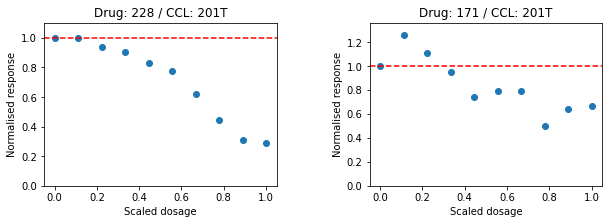

In [75]:
specific_samples = [(171, "201T"), #lower concentration
                    (228, "201T"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

### Conclusion: Low concentration didn't work well (but effect was recognisable), so they increased the concentration 4 times (case for drug_id=228) ???

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
109714,no-11,908450,205,205_908450,2,10.24,0,0.111111,0.222222,0.333333,...,0.945275,0.978555,0.958461,0.982709,0.958805,1.022682,0.988976,Avagacestat,no-11,0
161336,no-11,908450,1072,1072_908450,2,5.00,0,0.111111,0.222222,0.333333,...,0.674859,0.781196,0.928114,1.083455,0.847128,0.760488,0.847181,Avagacestat,no-11,0


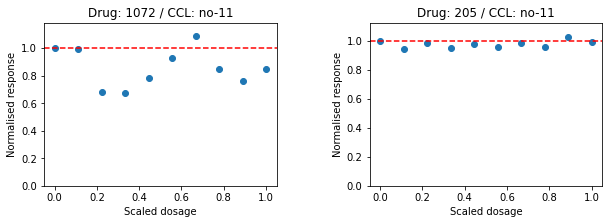

In [87]:
display(drug_curves[(drug_curves["drug_name"]=="Avagacestat") & (drug_curves["CCL_name"]=="no-11")])

specific_samples = [(1072, "no-11"), #lower concentration
                    (205, "no-11"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

### Need for explanation: Some effect for low concentration and no effect for higher concentration???

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
122793,no-10,908452,205,205_908452,2,10.24,0,0.111111,0.222222,0.333333,...,0.988966,0.972152,0.976856,0.985122,0.973397,0.956278,1.046807,Avagacestat,no-10,0
167111,no-10,908452,1072,1072_908452,2,5.00,0,0.111111,0.222222,0.333333,...,0.953071,0.913611,0.964856,1.132595,0.893639,0.887503,0.885085,Avagacestat,no-10,0


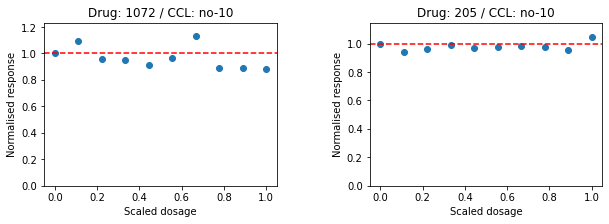

In [86]:
display(drug_curves[(drug_curves["drug_name"]=="Avagacestat") & (drug_curves["CCL_name"]=="no-10")])

specific_samples = [(1072, "no-10"), #lower concentration
                    (205, "no-10"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
84299,YAPC,909904,205,205_909904,2,10.24,0,0.111111,0.222222,0.333333,...,0.991167,0.974232,0.962564,0.988538,0.993025,1.038742,1.009257,Avagacestat,YAPC,0
173538,YAPC,909904,1072,1072_909904,2,5.00,0,0.111111,0.222222,0.333333,...,0.916409,0.882748,0.865984,0.873287,0.978138,0.912739,0.885363,Avagacestat,YAPC,0


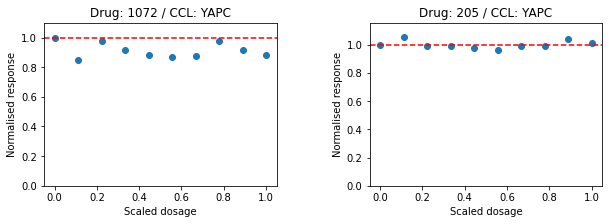

In [88]:
display(drug_curves[(drug_curves["drug_name"]=="Avagacestat") & (drug_curves["CCL_name"]=="YAPC")])

specific_samples = [(1072, "YAPC"), #lower concentration
                    (205, "YAPC"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

### Conclusion: Strange case for Avagacestat

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
30665,CAL-54,910952,156,156_910952,2,5.12,0,0.111111,0.222222,0.333333,...,0.790953,0.425658,0.968756,0.512320,0.831580,0.742309,0.343859,AZD6482,CAL-54,0
151706,CAL-54,910952,1066,1066_910952,2,5.00,0,0.111111,0.222222,0.333333,...,0.666333,0.746706,0.593387,0.510218,0.480783,0.438435,0.472617,AZD6482,CAL-54,0


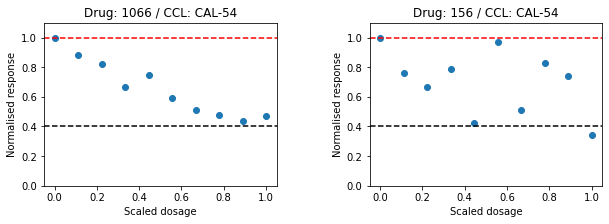

In [95]:
display(drug_curves[(drug_curves["drug_name"]=="AZD6482") & (drug_curves["CCL_name"]=="CAL-54")])

specific_samples = [(1066, "CAL-54"), #lower concentration
                    (156, "CAL-54"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1, lower_limit=0.4)

# Almost the same concentrations!!!

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
175276,22RV1,924100,1017,1017_924100,2,5.0,0,0.111111,0.222222,0.333333,...,1.175802,1.307469,1.236142,1.111566,1.129138,1.293295,0.949727,Olaparib,22RV1,0
210290,22RV1,924100,1495,1495_924100,4,10.0,0,0.200000,0.400000,0.600000,...,0.946075,1.015209,0.819707,NaN,NaN,NaN,NaN,Olaparib,22RV1,4


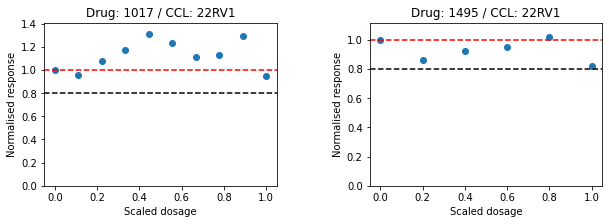

In [108]:
display(drug_curves[(drug_curves["drug_name"]=="Olaparib") & (drug_curves["CCL_name"]=="22RV1")])

specific_samples = [(1017, "22RV1"), #lower concentration
                    (1495, "22RV1"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1, lower_limit=0.8)

## Pairs with one concentration and two records

In [57]:
df_multi[df_multi["compare"] == -1]["n_conc"].value_counts()

1    3208
Name: n_conc, dtype: int64

In [59]:
df_multi[(df_multi["compare"]==-1)]

n_conc  n_samples  sum_missing  compare
drug_name   CCL_name                                         
PLX-4720    22RV1          1          2            4       -1
            23132-87       1          2            4       -1
            42-MG-BA       1          2            4       -1
            451Lu          1          2            4       -1
            5637           1          2            4       -1
...                      ...        ...          ...      ...
Selumetinib YKG-1          1          2            4       -1
            YT             1          2            4       -1
            ZR-75-30       1          2            4       -1
            huH-1          1          2            4       -1
            no-11          1          2            4       -1

[3208 rows x 4 columns]

In [128]:
multi_pairs = list(df_multi[(df_multi["compare"]==-1)].index.unique())
len(multi_pairs)

3208

In [132]:
[multi_pairs[i] for i in [10, 1000, 2000, 3000]]

[('PLX-4720', '8305C'),
 ('Pictilisib', 'EN'),
 ('Refametinib', 'LS-411N'),
 ('Selumetinib', 'OVKATE')]

### One concentration and 2 records for each pair

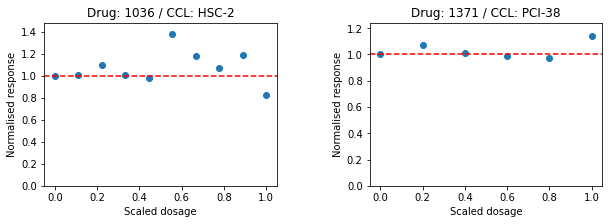

In [133]:
drug_curves[(drug_curves["drug_name"]=="PLX-4720")& (drug_curves["CCL_name"]=="22RV1")]

specific_samples = [(1036, "HSC-2"),
                    (1371, "PCI-38"),
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm, drug_col ="DRUG_ID",
            upper_limit =1)

### Hypothesis: for the pairs drug+CCL with one concentraion and two records, one of the records is reduced, i.e has missing values

In [62]:
nul_samples = df_multi[(df_multi["compare"]==-1) & (df_multi["sum_missing"]>0)].index.unique()

print("Total number of multiples:", len(multi_pairs))
print("Number of pairs with missing data:", len(nul_samples))

Total number of multiples: 3208
Number of pairs with missing data: 3208


### Conclusions: for all the pairs drug+CCL with one concentraion and two records, one of the records is reduced, i.e has missing values

# Part 2: Missing values

In [112]:
drug_curves["count_missing"] = drug_curves[response_norm].isnull().sum(axis=1)
drug_curves["count_missing"].value_counts()

0    191644
4     33740
Name: count_missing, dtype: int64

In [114]:
df = drug_curves[drug_curves["count_missing"]!=0]
df[["drug_name", "CCL_name"] + conc_columns + response_norm].head()

,drug_name,CCL_name,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,fd_num_5,fd_num_6,fd_num_7,...,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
191644,IOX2,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.010153,1.029382,1.114285,1.040530,1.115383,NaN,NaN,NaN,NaN
191645,UNC0638,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.075736,1.118267,1.005392,1.133969,1.086137,NaN,NaN,NaN,NaN
191646,UNC1215,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.016970,1.016753,1.000224,1.052226,1.004884,NaN,NaN,NaN,NaN
191647,Tamoxifen,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.057518,1.027474,0.978189,1.047974,0.962143,NaN,NaN,NaN,NaN
191648,(5Z)-7-Oxozeaenol,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,0.900644,0.945512,0.820547,0.208470,0.174570,NaN,NaN,NaN,NaN


## Conclusion: 33740 profiles have only 6 points (instead of usual 10)

Number of samples with missing data 33740


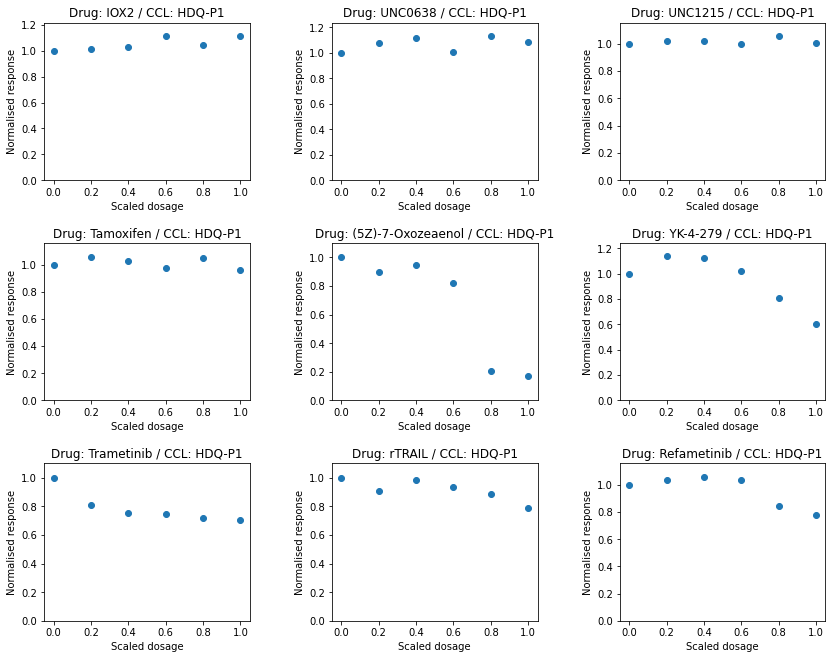

In [21]:
df = drug_curves[drug_curves["count_missing"]!=0]
print("Number of samples with missing data", df.shape[0])

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names)

## Hypothesis: for all the records with missing data there is a "dublicate" with the whole range

In [147]:
drug_curves["count_missing"] = drug_curves[response_norm].isnull().sum(axis=1)
conc_gr = drug_curves.groupby(["drug_name", "CCL_name"]).agg(n_conc = ("MAX_CONC", "nunique"),
                                                            n_samples = ("MAX_CONC", "count"),
                                                            sum_missing = ("count_missing", "sum"))


conc_gr.groupby(["sum_missing", "n_samples"]).agg(count = ("n_conc", "count"))

count
sum_missing n_samples        
0           1          177202
            2            2661
4           1           24620
            2            9120

### Conclusion: Among 33740 profiles with missing points, only 9120 have dublicates/alternatives

## Some of the profiles with missing data are not so bad

Number of not bad data: 1389


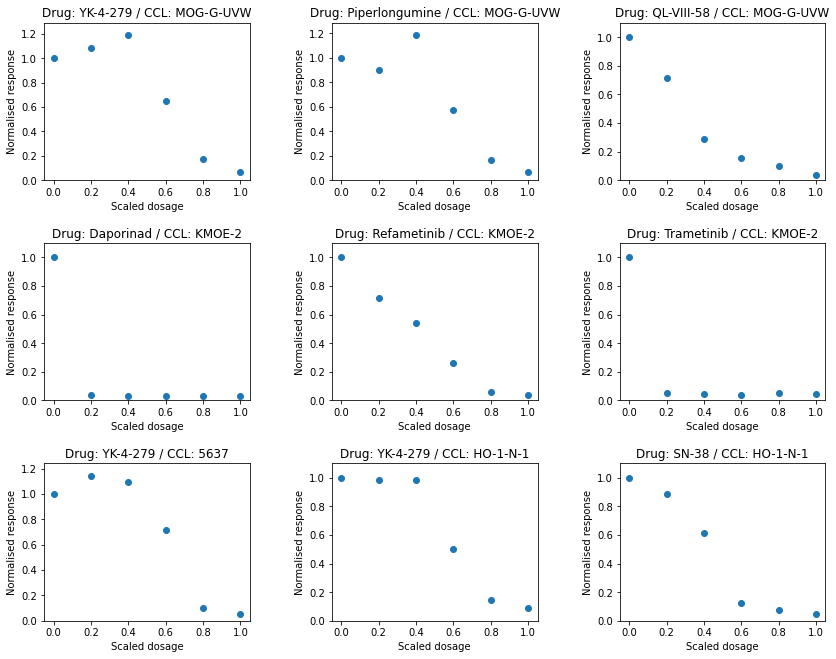

In [64]:
df = drug_curves[(drug_curves["count_missing"]!=0 )
                 & (drug_curves["norm_cells_4"]<0.2)
                 & (drug_curves["norm_cells_5"]<0.2)
                ]
                 
print("Number of not bad data:", df.shape[0])

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[60:69],
                  drug_dict = drug_names, CCL_dict = CCL_names)

## Ambigous data: Are some points wrong?

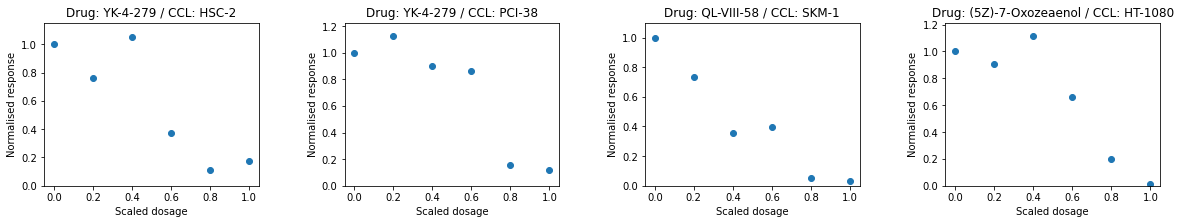

In [66]:
specific_samples = [("YK-4-279", "HSC-2"),
                    ("YK-4-279", "PCI-38"),
                   ("QL-VIII-58", "SKM-1"),
                    ("(5Z)-7-Oxozeaenol", "HT-1080")
                   ]
ShowSpecific(drug_curves, specific_samples, conc_columns, response_norm)

# Part 1: Explore  curves with normalised responses above 1.0

In [68]:
%%time
# Number of responses > 1
drug_curves["high_responses"] = drug_curves[response_norm].apply(lambda row: sum(row>1), axis=1)
drug_curves[["high_responses"]+ response_norm]

CPU times: user 25.2 s, sys: 11.2 ms, total: 25.2 s
Wall time: 25.2 s


In [5]:
bad_data = drug_curves[drug_curves["high_responses"]>1]
print("Original data:", drug_curves.shape)
print("Ambiguos data:", bad_data.shape)

Original data: (225384, 47)
Ambiguos data: (127590, 47)


### Note: Half of the data can be regarded as ambiguous!!!

In [6]:
bad_data["high_responses"].value_counts()

2    28485
3    24334
4    20015
5    17201
6    12366
7    10712
8     8487
9     5990
Name: high_responses, dtype: int64

## Bad data by drug

In [7]:
%%time
dr1 = drug_curves.groupby(["DRUG_ID"], as_index=False).agg(curves_count_all = ("COSMIC_ID", "count"))

dr2 = bad_data.groupby(["DRUG_ID"], as_index=False).agg(curves_count_bad = ("COSMIC_ID", "count"),
                                                       min_bad_responses = ("high_responses", "min"),
                                                        max_bad_response = ("high_responses", "max"),
                                                        avg_bad_responses = ("high_responses", "mean"),
                                                       )

dr2["avg_bad_responses"] = round(dr2["avg_bad_responses"], 2)

dr = pd.merge(right = dr1, left =dr2, on="DRUG_ID", how="left")
dr["drug_name"] = dr["DRUG_ID"].map(drug_names)
dr["percent_bad"] = round(dr["curves_count_bad"]/dr["curves_count_all"], 3)

show_columns = ['DRUG_ID', 'drug_name', 'percent_bad', 'curves_count_all','curves_count_bad', 
                'min_bad_responses', 'max_bad_response','avg_bad_responses']
dr = dr[show_columns].copy()

CPU times: user 23.9 ms, sys: 7.78 ms, total: 31.7 ms
Wall time: 30.2 ms


In [8]:
dr.sort_values("percent_bad", ascending = False, inplace=True)
dr.head(10)

,DRUG_ID,drug_name,percent_bad,curves_count_all,curves_count_bad,min_bad_responses,max_bad_response,avg_bad_responses
190,1025,SB216763,0.954,786,750,2,9,5.98
197,1033,Vismodegib,0.950,893,848,2,9,5.93
47,150,Bicalutamide,0.947,932,883,2,9,6.00
161,332,XMD15-27,0.947,980,928,2,9,6.50
183,1018,Veliparib,0.919,894,822,2,9,5.79
178,1013,Nilotinib,0.915,844,772,2,9,5.69
182,1017,Olaparib,0.908,894,812,2,9,5.53
185,1020,Lenalidomide,0.908,894,812,2,9,5.58
232,1170,CCT-018159,0.901,945,851,2,9,4.93
163,341,Selisistat,0.899,975,877,2,9,5.77


## Bad data by CCL

In [9]:
%%time
cl1 = drug_curves.groupby(["COSMIC_ID"], as_index=False).agg(curves_count_all = ("DRUG_ID", "count"))

cl2 = bad_data.groupby(["COSMIC_ID"], as_index=False).agg(curves_count_bad = ("DRUG_ID", "count"),
                                                       min_bad_responses = ("high_responses", "min"),
                                                        max_bad_response = ("high_responses", "max"),
                                                        avg_bad_responses = ("high_responses", "mean"),
                                                       )

cl2["avg_bad_responses"] = round(cl2["avg_bad_responses"], 2)

cl = pd.merge(right = cl1, left =cl2, on="COSMIC_ID", how="left")
cl["CCL_name"] = cl["COSMIC_ID"].map(CCL_names)
cl["percent_bad"] = round(cl["curves_count_bad"]/cl["curves_count_all"], 3)

show_columns = ['COSMIC_ID', 'CCL_name', 'percent_bad', 'curves_count_all','curves_count_bad', 
                'min_bad_responses', 'max_bad_response','avg_bad_responses']
cl = cl[show_columns].copy()

CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 29.6 ms


In [10]:
cl.sort_values("percent_bad", ascending = False, inplace=True)
cl.head(10)

,COSMIC_ID,CCL_name,percent_bad,curves_count_all,curves_count_bad,min_bad_responses,max_bad_response,avg_bad_responses
62,688022,NCI-H378,1.000,2,2,5,5,5.00
670,924241,NCI-H250,1.000,1,1,5,5,5.00
985,1330969,NCI-H1404,0.837,43,36,2,9,5.44
75,713880,SBC-5,0.816,217,177,2,9,5.45
564,909907,ZR-75-30,0.813,91,74,2,9,5.66
503,909711,SCH,0.806,252,203,2,9,5.67
894,1298162,K8,0.802,126,101,2,9,5.26
402,907799,MC116,0.802,258,207,2,9,4.79
714,949092,CP67-MEL,0.800,25,20,2,6,3.25
378,907312,KU-19-19,0.793,222,176,2,9,5.03


## Check whether bad data are actually bad

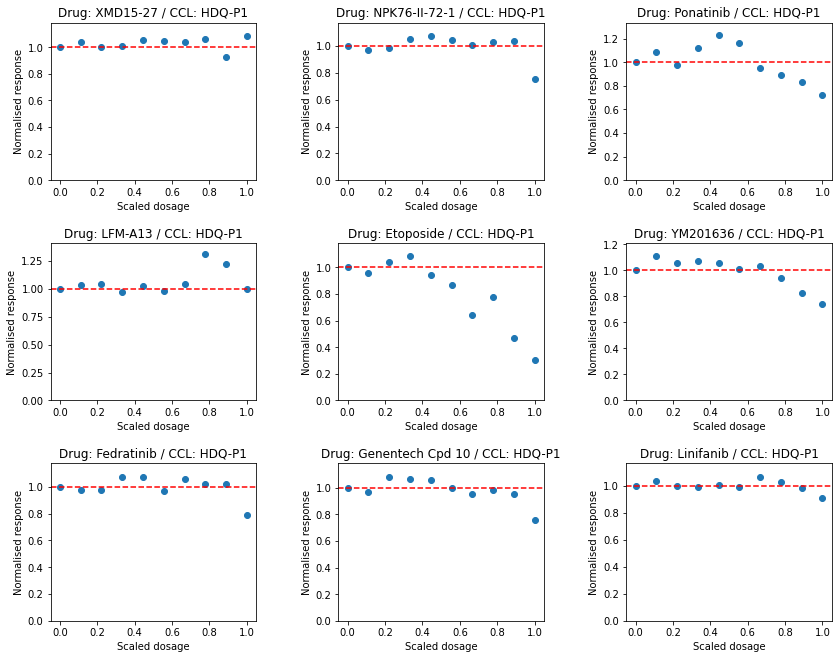

In [12]:
df = bad_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 2 bad responses

Number of samples with 2 bad responses: 28485


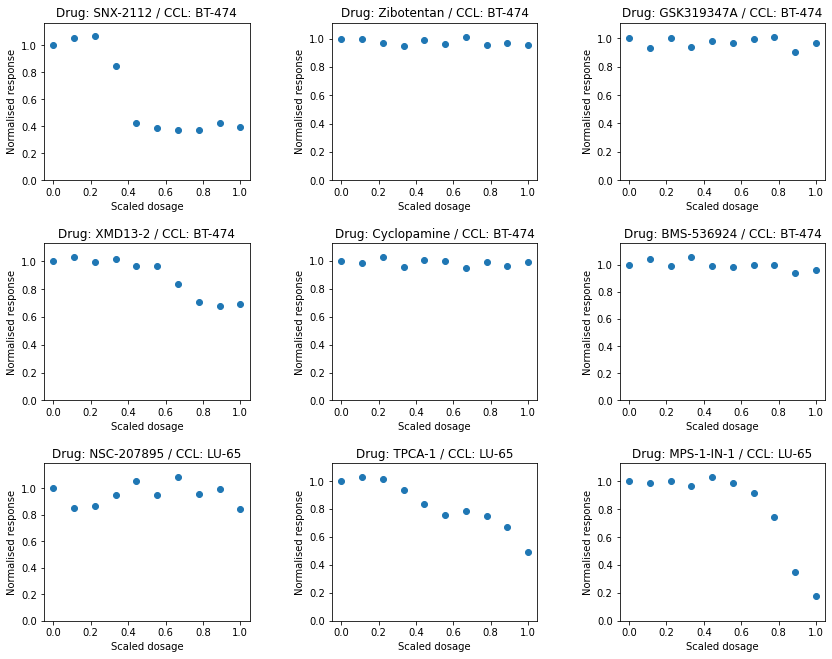

In [13]:
N = 2
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

### Among samples with only 2 norm_responses >1 some data are not so bad

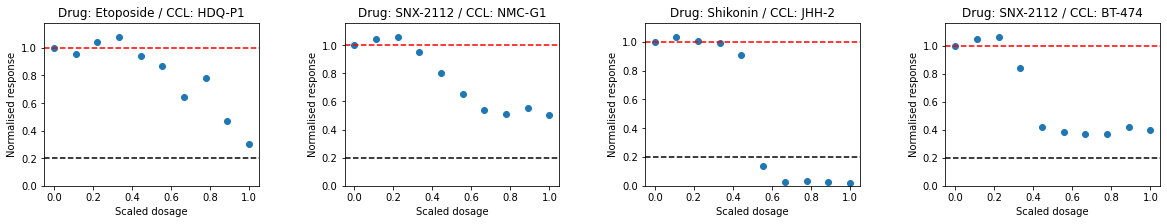

In [14]:
specific_samples = [("Etoposide", "HDQ-P1"),
                    ("SNX-2112", "NMC-G1"),
                    ("Shikonin", "JHH-2"),
                    ("SNX-2112", "BT-474")
                   ]
ShowSpecific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 2 bad responses, but with 2 last responses below 0.2: 2728


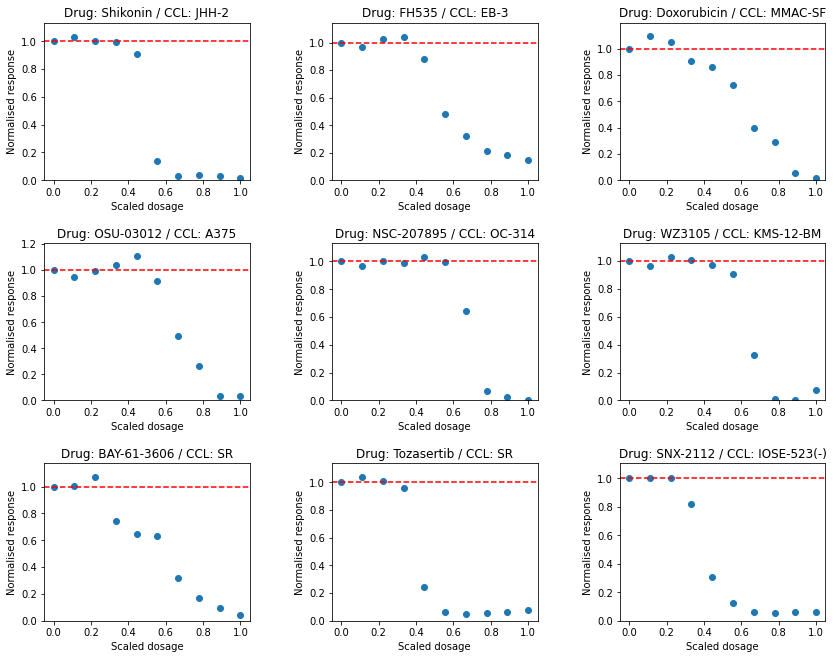

In [15]:
N = 2
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

### Conclusion - we can't delete just samples which with 2 responses>1.0
### The question: What is the accuracy of measuring responses? <br>Can we treat samples with responses up to 1.01 as valid ones?

## Samples with 3 bad responses

Number of samples with 3 bad responses: 24334


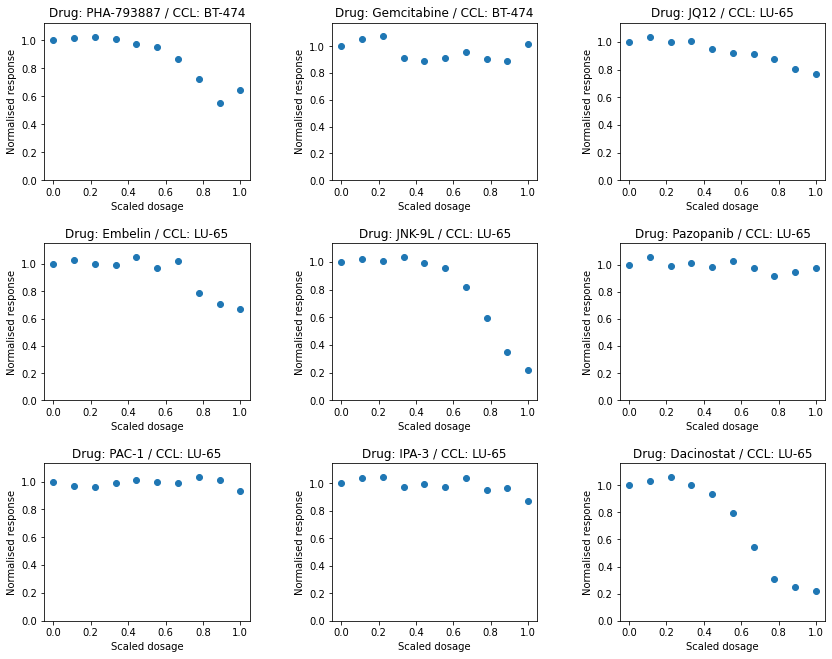

In [31]:
N = 3
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[30:39],
                  drug_dict = drug_names, CCL_dict = CCL_names)

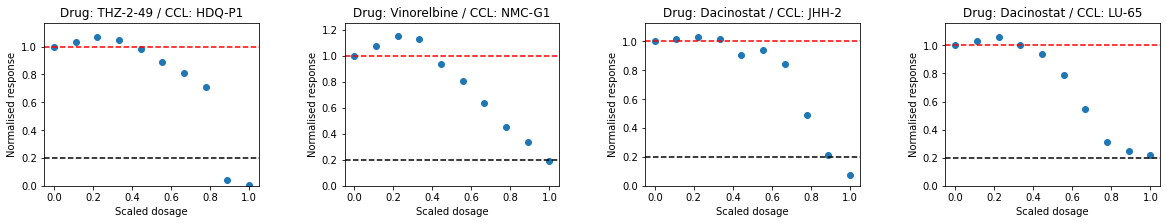

In [32]:
specific_samples = [("THZ-2-49", "HDQ-P1"),
                    ("Vinorelbine", "NMC-G1"),
                    ("Dacinostat", "JHH-2"),
                    ("Dacinostat", "LU-65")
                   ]
ShowSpecific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 3 bad responses, but with 2 last responses below 0.2: 1780


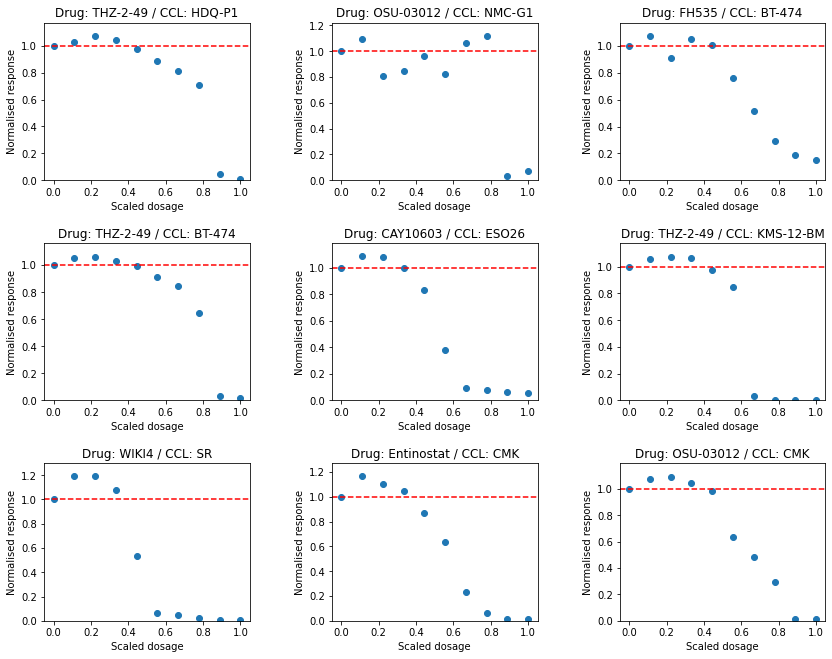

In [18]:
N = 3
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 4 bad responses 

Number of samples with 4 bad responses: 20015


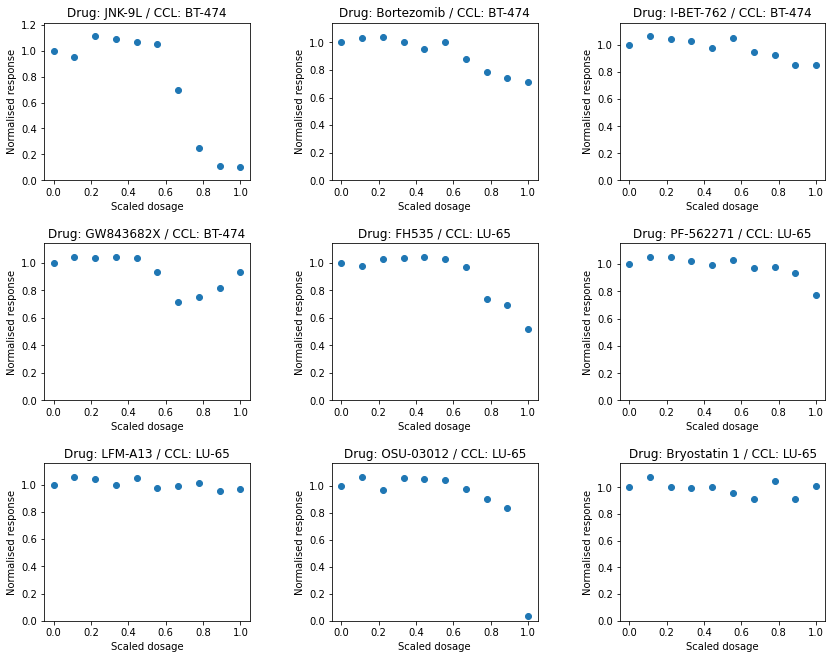

In [26]:
N = 4
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

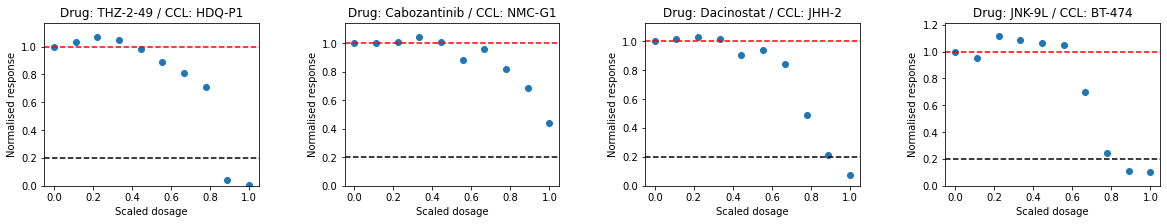

In [30]:
specific_samples = [("THZ-2-49", "HDQ-P1"),
                    ("Cabozantinib", "NMC-G1"),
                    ("Dacinostat", "JHH-2"),
                    ("JNK-9L", "BT-474")
                   ]
ShowSpecific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 4 bad responses, but with 2 last responses below 0.2: 879


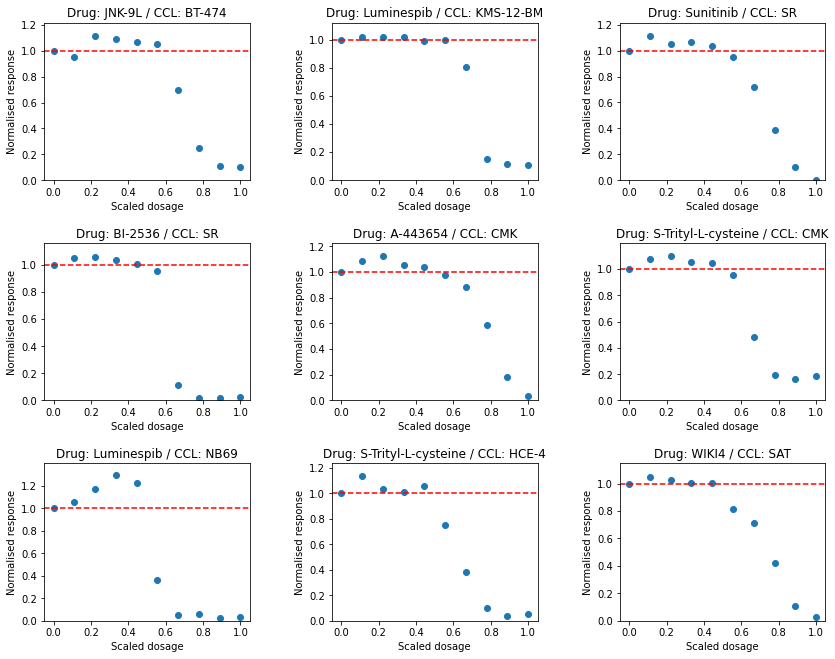

In [34]:
N = 4
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 5+ bad responses

Number of samples with more than 5 bad responses: 54756


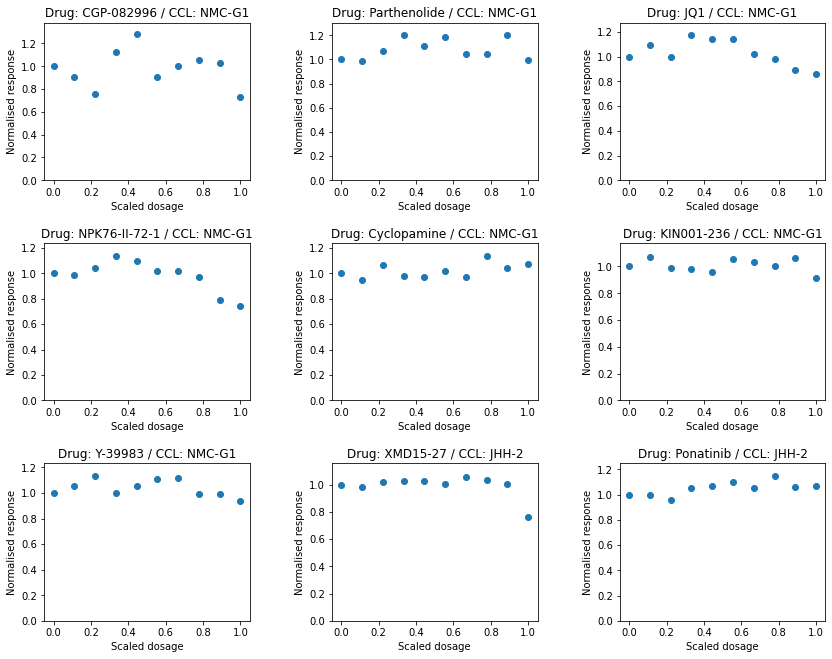

In [35]:
N = 5
df = bad_data[bad_data["high_responses"]>=N]
print("Number of samples with more than %d bad responses: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

Number of samples with 5 bad responses, but with 2 last responses below 0.2: 441


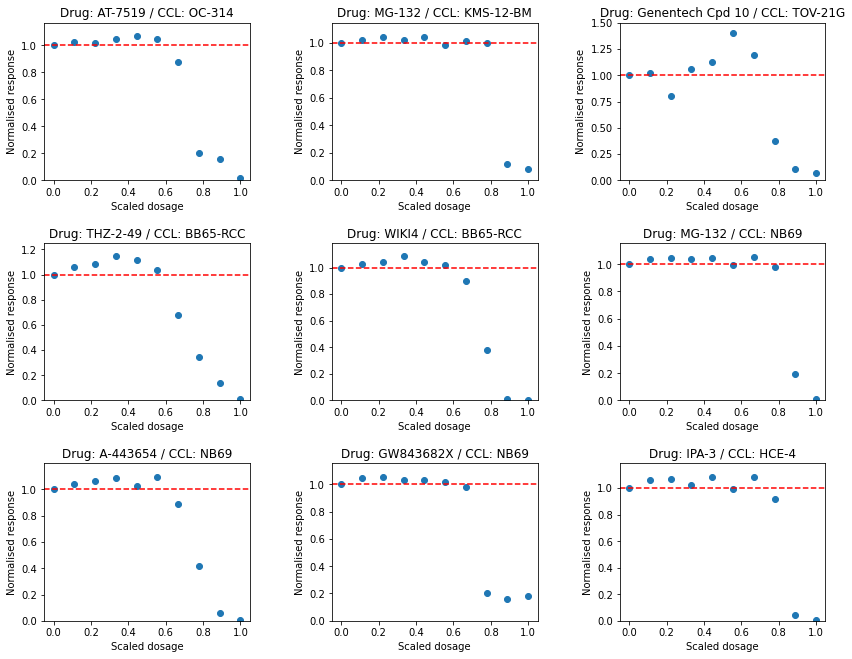

In [36]:
N = 5
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 6 bad responses, but with 2 last responses below 0.2: 135


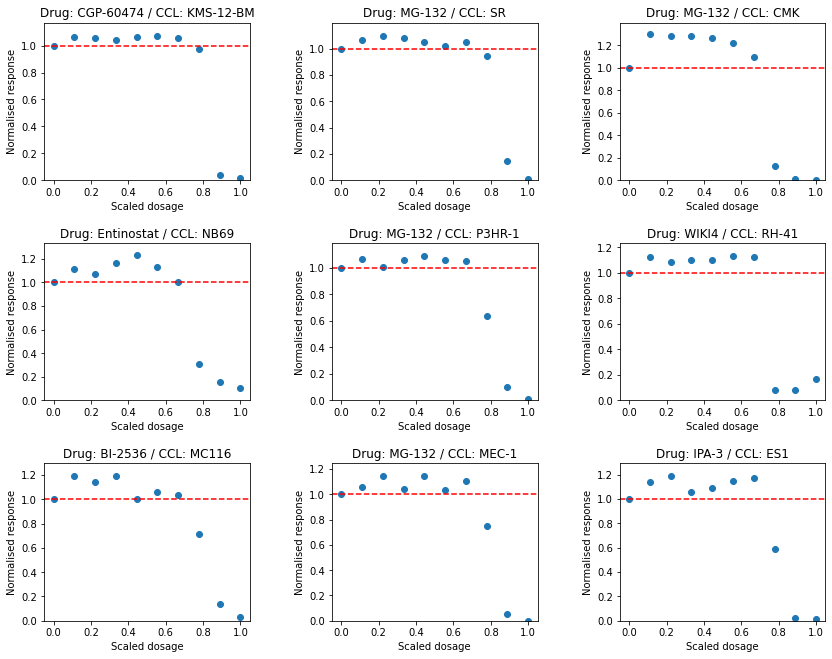

In [37]:
N = 6
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 7 bad responses, but with 2 last responses below 0.2: 18


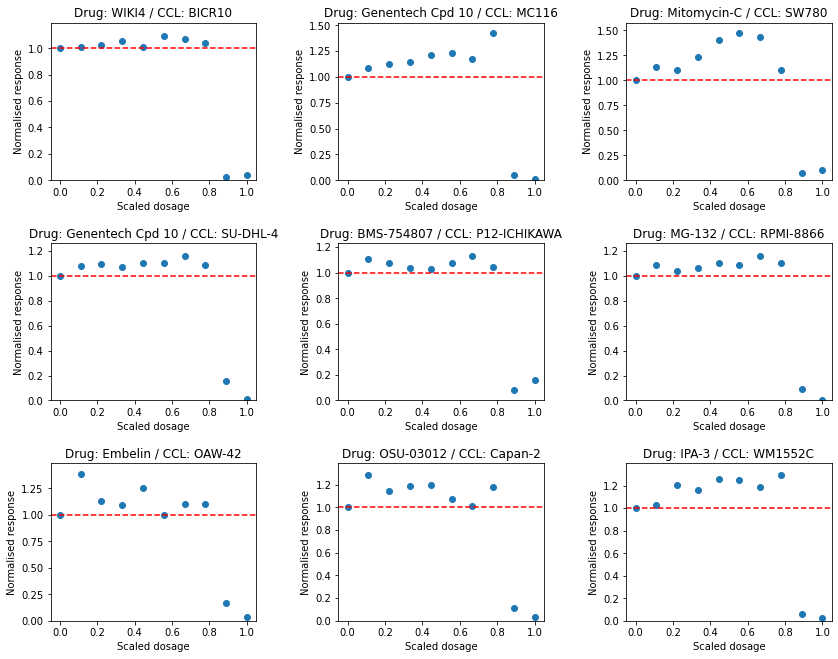

In [38]:
N = 7
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

In [40]:
N = 8
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 8 bad responses, but with 2 last responses below 0.2: 0


<Figure size 1008x792 with 0 Axes>

In [41]:
N = 9
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 9 bad responses, but with 2 last responses below 0.2: 0


<Figure size 1008x792 with 0 Axes>

## Conclusion from Part 1: Curves with up to 7 suspiciously high normalised responses look pretty reasonable

# Part 2: Explore curves with normalised response above 1 but low final response

In [67]:
%%time
drug_curves["low_response_02"] = drug_curves[response_norm].apply(lambda row: sum(row<=0.2), axis=1)
drug_curves["low_response_04"] = drug_curves[response_norm].apply(lambda row: sum(row<=0.4), axis=1)

CPU times: user 49.6 s, sys: 26.1 ms, total: 49.6 s
Wall time: 49.6 s


In [45]:
not_bad_02 = drug_curves[(drug_curves["high_responses"]>1) & (drug_curves["low_response_02"])]
not_bad_04 = drug_curves[(drug_curves["high_responses"]>1) & (drug_curves["low_response_04"])]
print("Number of all suspicious samples:", bad_data.shape[0])
print("\nNumber of potentionally good samples among all bad data:")
print("With responses below 0.2:", not_bad_02.shape[0])
print("With responses below 0.4:", not_bad_04.shape[0])

Number of all suspicious samples: 127590

Number of potentionally good samples among all bad data:
With responses below 0.2: 9892
With responses below 0.4: 16438


In [46]:
not_bad_02["low_response_02"].value_counts()

1    7742
3    1755
5     387
7       8
Name: low_response_02, dtype: int64

In [47]:
not_bad_04["low_response_04"].value_counts()

1    12144
3     3301
5      974
7       19
Name: low_response_04, dtype: int64

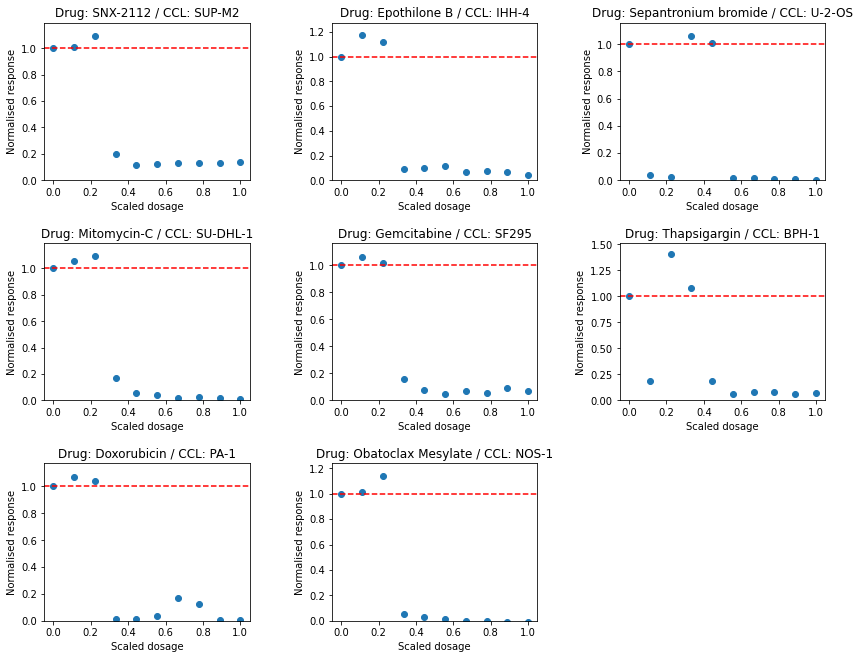

In [49]:
df = not_bad_02[not_bad_02["low_response_02"]==7]
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

# Part 3: Repeat with an additional constrain 
## Among all "middle" datapoints a subsequent point should not be higher than antecedent by some limit

In [ ]:
def CutOffOutliers_2(df, response_columns, middle_points_limit= -0.2):
    df = df.copy()
    cols= []
    for j in range(1, len(response_columns)-1): # two first and two last are already assessed
        df["delta_"+str(j)] = df[response_columns[j]] - df[response_columns[j+1]]
        cols.append("delta_"+str(j))
    df["check_delta"] = df[cols].apply(lambda row: sum(row<middle_points_limit), axis=1)
    df = df[df["check_delta"]==0]
    #df.drop(cols+["check_delta"], axis=1, inplace=True)
    
    return df  

#  CutOffOutliers_2 is slower than CutOffOutliers, CutOffOutliers remove NaN, but CutOffOutliers leaves NaN
def CutOffOutliers(df, response_columns, middle_points_limit=-0.2):
    df = df.copy()
    for j in range(1, len(response_columns)-1): # two first and two last are already assessed
        df = df[(df[response_columns[j]] - df[response_columns[j+1]])>middle_points_limit]
    return df  

In [82]:
not_bad_02_2 = CutOffOutliers(drug_curves, middle_points_limit=-0.2, response_columns = response_norm)

print("Before filtration: %d, After filtration: %d" % (not_bad_04.shape[0], not_bad_02_2.shape[0]))
not_bad_02_2["low_response_02"].value_counts()

Before filtration: 16438, After filtration: 161288


0    126709
1     13086
2      6440
3      5122
4      3851
5      2509
6      1553
7       858
9       678
8       482
Name: low_response_02, dtype: int64

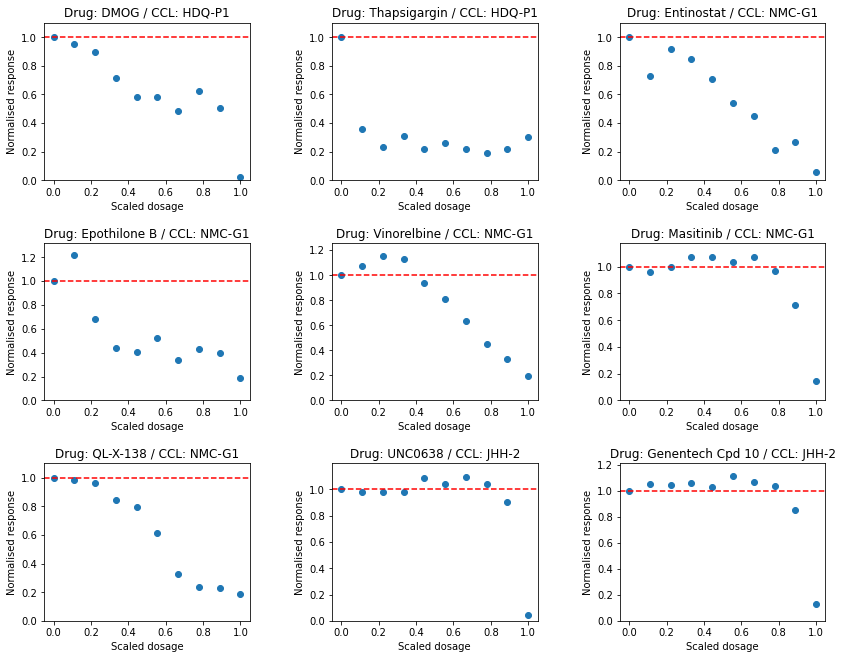

In [83]:
df = not_bad_02_2[not_bad_02_2["low_response_02"]==1]
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

In [131]:
%%time
df1 = CutOffOutliers_2(drug_curves, middle_points_limit=-0.2, response_columns = response_norm)
print(df1.shape)

(190245, 54)
CPU times: user 24.7 s, sys: 46.7 ms, total: 24.7 s
Wall time: 24.7 s


In [132]:
df1.head(10)

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,CCL_name,delta_1,delta_2,delta_3,delta_4,delta_5,delta_6,delta_7,delta_8,check_delta
0,HDQ-P1,1290922,332,332_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,HDQ-P1,0.041323,-0.007695,-0.050008,0.005500,0.014643,-0.027439,0.137716,-0.157952,0
1,HDQ-P1,1290922,257,257_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,HDQ-P1,-0.018165,-0.065125,-0.020100,0.024603,0.038780,-0.017536,-0.009678,0.283843,0
3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,0.333333,...,HDQ-P1,0.107179,-0.137640,-0.116328,0.072507,0.213451,0.060141,0.053431,0.114657,0
5,HDQ-P1,1290922,134,134_1290922,2,16.000,0,0.111111,0.222222,0.333333,...,HDQ-P1,-0.086262,-0.037968,0.140024,0.072373,0.227607,-0.135887,0.305185,0.169906,0
6,HDQ-P1,1290922,310,310_1290922,2,5.120,0,0.111111,0.222222,0.333333,...,HDQ-P1,0.055477,-0.020955,0.016534,0.046440,-0.018870,0.091796,0.115926,0.079019,0
7,HDQ-P1,1290922,306,306_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,HDQ-P1,0.000697,-0.092673,-0.004322,0.108280,-0.094574,0.037522,0.003878,0.232032,0
8,HDQ-P1,1290922,225,225_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,HDQ-P1,-0.112328,0.015075,0.008375,0.060161,0.044653,-0.027163,0.031801,0.192263,0
9,HDQ-P1,1290922,277,277_1290922,2,1.024,0,0.111111,0.222222,0.333333,...,HDQ-P1,0.037060,0.011604,-0.019839,0.018702,-0.075423,0.040148,0.042903,0.076408,0
11,HDQ-P1,1290922,253,253_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,HDQ-P1,-0.021152,0.059054,-0.030098,0.032924,-0.065646,0.008322,0.031467,0.005884,0
12,HDQ-P1,1290922,238,238_1290922,2,20.000,0,0.111111,0.222222,0.333333,...,HDQ-P1,-0.079210,0.142904,-0.064221,0.055599,-0.017411,0.076496,-0.003631,0.002590,0


In [137]:
df1[["drug_name", "CCL_name"]+["check_delta"] + ["delta_"+str(j) for j in range(1,9)]]

,drug_name,CCL_name,check_delta,delta_1,delta_2,delta_3,delta_4,delta_5,delta_6,delta_7,delta_8
0,XMD15-27,HDQ-P1,0,0.041323,-0.007695,-0.050008,0.005500,0.014643,-0.027439,0.137716,-0.157952
1,NPK76-II-72-1,HDQ-P1,0,-0.018165,-0.065125,-0.020100,0.024603,0.038780,-0.017536,-0.009678,0.283843
3,Ponatinib,HDQ-P1,0,0.107179,-0.137640,-0.116328,0.072507,0.213451,0.060141,0.053431,0.114657
5,Etoposide,HDQ-P1,0,-0.086262,-0.037968,0.140024,0.072373,0.227607,-0.135887,0.305185,0.169906
6,YM201636,HDQ-P1,0,0.055477,-0.020955,0.016534,0.046440,-0.018870,0.091796,0.115926,0.079019
...,...,...,...,...,...,...,...,...,...,...,...
225372,UNC0638,LCLC-103H,0,-0.070641,-0.179279,-0.012917,-0.097538,NaN,NaN,NaN,NaN
225373,Pictilisib,MRK-nu-1,0,0.016952,-0.146463,-0.007317,-0.004329,NaN,NaN,NaN,NaN
225374,UNC0638,NCI-H226,0,-0.049271,-0.084592,0.009489,0.962647,NaN,NaN,NaN,NaN
225378,IOX2,J82,0,0.110550,-0.133158,-0.117548,0.099853,NaN,NaN,NaN,NaN


In [138]:
df1.dropna(axis=0).shape

(159192, 54)

In [121]:
%%time
df2 = CutOffOutliers_2(drug_curves, middle_points_limit=-0.2, response_columns = response_norm)
print(df2.shape)

(159192, 56)
CPU times: user 356 ms, sys: 93.3 ms, total: 449 ms
Wall time: 420 ms


In [100]:
df1.shape, df.shape

((0, 49), (13086, 49))

In [93]:
not_bad_02_2 = CutOffOutliers(not_bad_02, middle_points_limit=-0.2, response_columns = response_norm)

norm_cells_1 norm_cells_2
norm_cells_2 norm_cells_3
norm_cells_3 norm_cells_4
norm_cells_4 norm_cells_5
norm_cells_5 norm_cells_6
norm_cells_6 norm_cells_7
norm_cells_7 norm_cells_8
norm_cells_8 norm_cells_9


## FIltration Approach 1

1. Remove all the curves where the normalised response value is greater than one at zero dosage. 
2. Compute the Area Under the Curve (AUC) for all the curves. 
3. Leave only those curves with an AUC>0.7.  
4. Compute the Spearman correlation coefficient between the normalised response and the scaled dosage (so the x-axis and the y-axis).
5. Further remove the curves for which the Spearman correlation coefficient is zero or positive. 

The reason for point 5 is that one would expect the correlation between the normalised response and the scaled dosage to be negative (an increase of dosage involves a reduction of response). And what one can see for some curves, is that even though the AUC is significantly large (e.g. >0.7) such correlations are zero or positive, which doesn't make sense.


### Filtered data

**Filtering_curves**
(df, response_columns, filtering_scenario = [1,2,3], first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2], tolerance=0.05, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

filtering_scenario = [1,2,3]
1. Ensure that all the response are less than 1

2. Ensure that first and last points form a plateu
the minimal number of points are specified in the function arguments
by default, two points for both lpateus are considered
tolerance =0.05 values to ensure the points form a plateu
first_columns_to_compare = [1, 2]  - first two columns for plateu
last_columns_to_compare = [-1, -2] - last two columns for plateu

3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit

### Filtering scenario 1

In [7]:
df = FilteringCurves(drug_curves, filtering_scenario=[1], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)


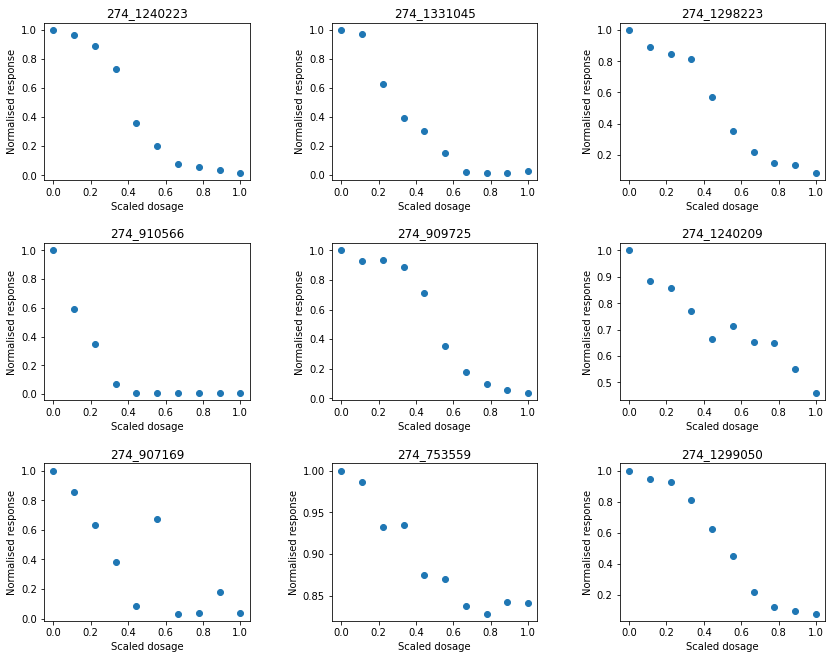

In [8]:
df2 = df[df["DRUG_ID"]==274]

ShowResponseCurves(drug_curves, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df2.index[:9])

### Figure for the report - Results of filtraion: Sigmoid and Linear trends

### Example of Valid Curves

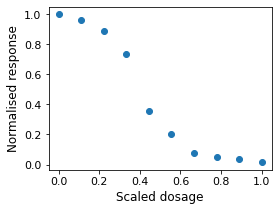

In [9]:
plt.figure(figsize=(4,3))
# Belinostat
ind = df[(df["DRUG_ID"]==274) &(df["COSMIC_ID"]==1240223)].index
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=11)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt_Fig1a.png", bbox_inches='tight', dpi=360)

### Example of Not good response (No plateus)

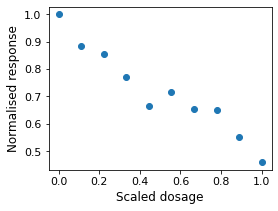

In [10]:
plt.figure(figsize=(4,3))
# Belinostat
ind = df[(df["DRUG_ID"]==274) &(df["COSMIC_ID"]==1240209)].index
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=11)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt_Fig1b.png", bbox_inches='tight', dpi=360)

### Filtering scenario 1+2 

In [11]:
df = FilteringCurves(drug_curves, filtering_scenario=[1, 2], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)


### Figures for the report - Invalid data left after filtration

Presence of "plateus, when difference between points is in the specified range, but min response is >0.8

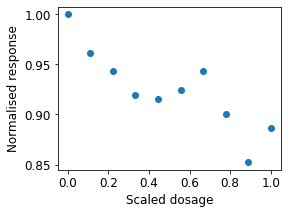

In [12]:
plt.figure(figsize=(4,3))
ind = df[(df["DRUG_ID"]==171) &(df["COSMIC_ID"]== 753551)].index
ind = df.index[10]
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=12)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
if SAVE_FIGURES:
    plt.savefig(_FOLDER_2+"filt2_1.png", bbox_inches='tight', dpi=360)

## Necessity for additional constrains

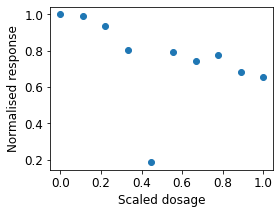

In [13]:
plt.figure(figsize=(4,3))
ind = df[(df["DRUG_ID"]==190) &(df["COSMIC_ID"]==908128)].index
# ind = df.index[1]
x = df.loc[ind, conc_columns]
y = df.loc[ind, response_norm]
plt.scatter(x, y)
plt.tick_params(labelsize=12)
plt.xlabel("Scaled dosage", fontsize=12)
plt.ylabel("Normalised response", fontsize=12);
# plt.savefig(_FOLDER_2+"filt2_2.png", bbox_inches='tight')

#### Solved by 3 criteria of filtration (Specified location of the plateus)

### Ambiguous samples found from further fitting

In [14]:
def show_one(df, drug_id, cosmic_id, print_title = True, save_name=None):
    plt.figure(figsize=(4,3))
    ind = df[(df["DRUG_ID"]==drug_id) &(df["COSMIC_ID"]==cosmic_id)].index

    x = df.loc[ind, conc_columns]
    y = df.loc[ind, response_norm]
    plt.scatter(x, y)
    plt.tick_params(labelsize=12)
    plt.xlabel("Scaled dosage", fontsize=12)
    plt.ylabel("Normalised response", fontsize=12)
    if print_title:
        plt.title(drug_names[drug_id]+"_"+str(cosmic_id));
    if save_name:
        plt.savefig(_FOLDER_2+save_name+".png", bbox_inches='tight')

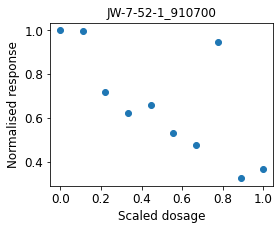

In [15]:
drug_id = 83
cosmic_id = 910700
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

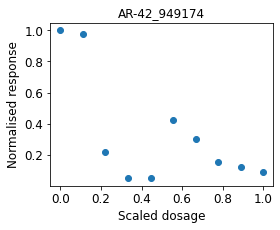

In [16]:
drug_id = 272
cosmic_id = 949174
# show_one(df,drug_id, cosmic_id, print_title= False, save_name=str(drug_id)+"_"+str(cosmic_id))
show_one(df,drug_id, cosmic_id, print_title= True)

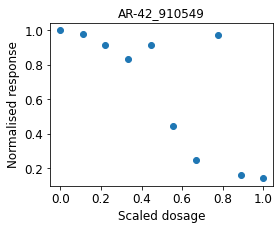

In [17]:
drug_id = 272
cosmic_id = 910549
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

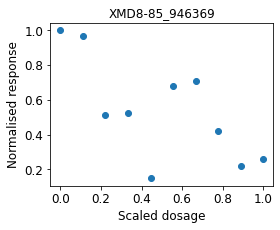

In [18]:
drug_id = 106
cosmic_id = 946369
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

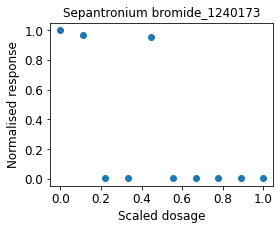

In [19]:
drug_id = 268
cosmic_id = 1240173
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

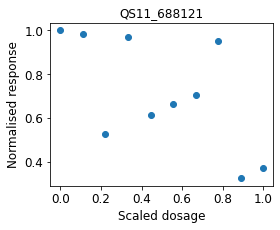

In [20]:
drug_id = 151
cosmic_id = 688121
show_one(df, drug_id, cosmic_id, save_name=str(drug_id)+"_"+str(cosmic_id))

## Possible 4-th filtering criteria:

There are 10 points in total
<br>Two first points and last two points are assumed to form a plateu, 
and we a filtering restriction for them to be in a secified range.

So our new constrain might be: for the middle points, a subsequent point should not be higher than antecedent by 0.2
And we want to visualise drug profiles which were filtered out by this criteria

In [21]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)
#df.to_csv(_FOLDER_3+"sigmoid_01.csv")

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2600, 46)


In [22]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.2)
#df.to_csv(_FOLDER_3+"sigmoid_02.csv")

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2719, 46)


In [23]:
j=3
response_columns = response_norm
middle_points_limit = -0.1
df_11 = df[(df[response_columns[j]] - df[response_columns[j+1]])<middle_points_limit]
middle_points_limit = -0.2
df_22 = df[(df[response_columns[j]] - df[response_columns[j+1]])<middle_points_limit]
print(df_11.shape)
df_11.head()

(22, 46)


,Unnamed: 0,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,...,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8,dif_first,dif_last
6444,6444,KP-2,1298218,201,201_1298218,2,0.032,0,0.111111,0.222222,...,-2.734774,-1.949405,1.356990,-1.992929,-2.065666,-0.385318,0.123753,-0.257777,0.039962,0.028642
143669,146792,EFM-19,906851,1024,1024_906851,2,2.000,0,0.111111,0.222222,...,-0.068292,-2.556213,1.394734,-2.826220,-1.514173,-1.262082,0.332951,-0.071578,0.045884,0.007953
20452,20452,GB-1,687568,136,136_687568,2,16.000,0,0.111111,0.222222,...,-0.815769,-2.980620,1.630969,-4.375554,-0.146770,-0.795832,-0.497917,0.281652,0.041330,0.031295
36109,36109,LOUCY,907789,299,299_907789,2,20.000,0,0.111111,0.222222,...,-3.958805,-1.409596,1.686667,-1.473844,-2.743984,-0.188720,-0.110520,-0.311394,0.041238,0.034599
37290,37290,HL-60,905938,133,133_905938,2,1.024,0,0.111111,0.222222,...,-1.178291,-0.927992,1.796717,-3.467556,-3.145334,0.235097,-1.605499,-0.388048,0.000567,0.043116


/home/marina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

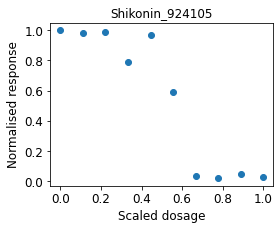

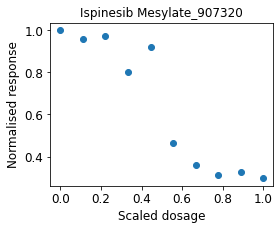

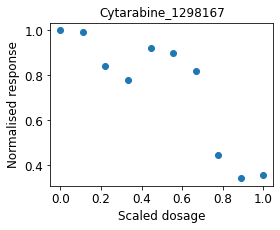

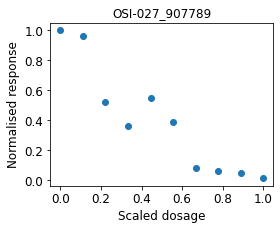

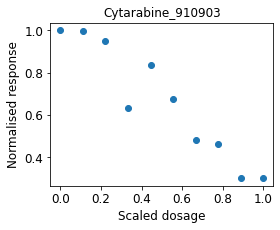

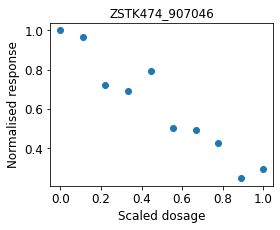

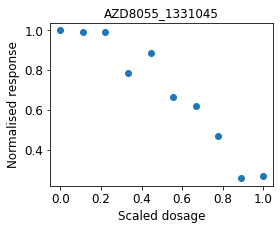

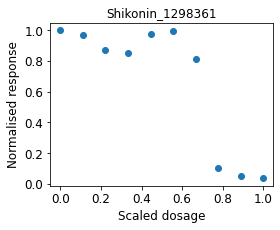

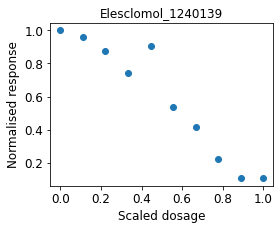

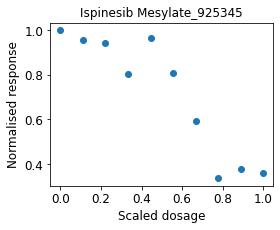

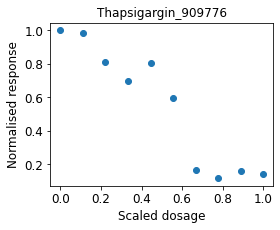

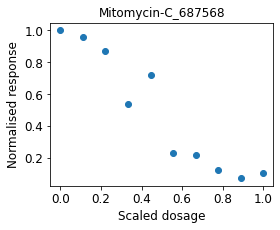

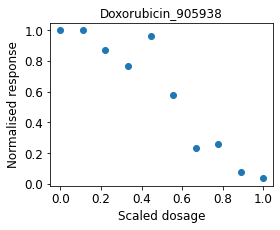

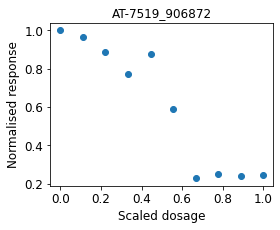

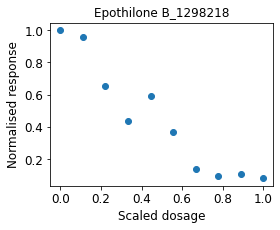

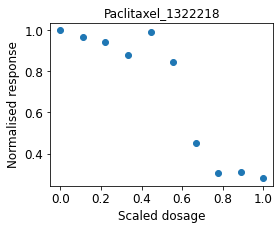

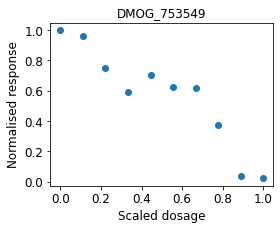

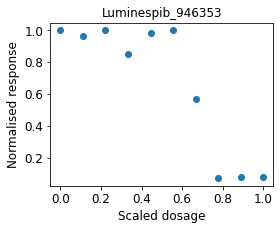

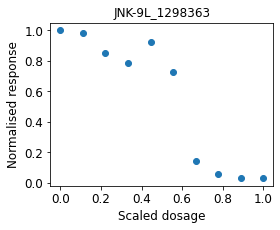

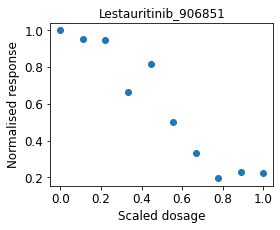

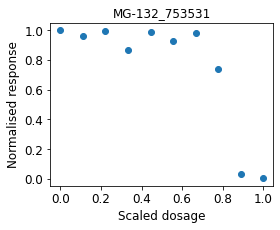

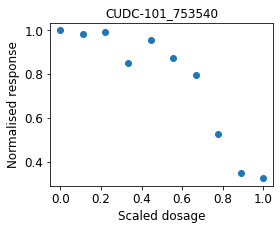

In [24]:
# difference between setting limit 0.2 and 0.1

ind_02_01 = set(df_11.index)- set(df_22.index)
len(ind_02_01)

for i, ind in enumerate(ind_02_01):
    plt.figure(i)
    drug_id = df_11.loc[ind, "DRUG_ID"]
    cosmic_id = df_11.loc[ind, "COSMIC_ID"]
    show_one(df, drug_id, cosmic_id, save_name =drug_names[drug_id]+"-"+str(cosmic_id))

/home/marina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

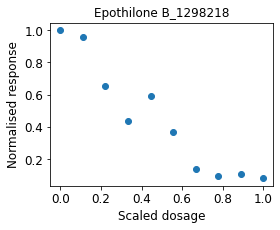

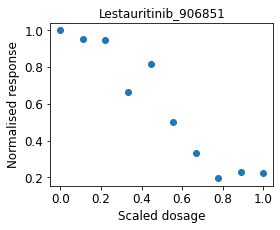

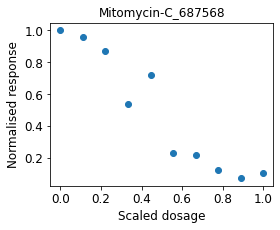

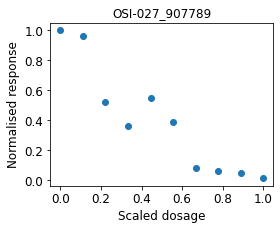

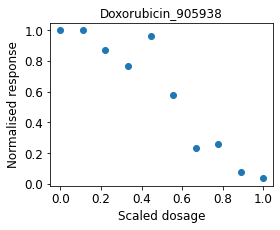

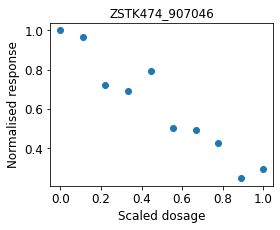

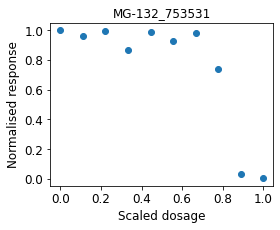

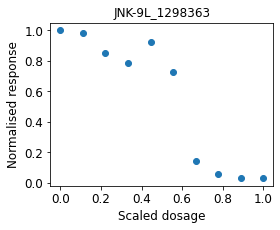

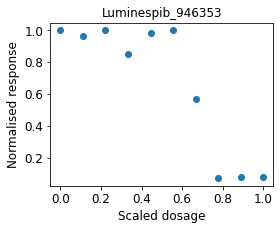

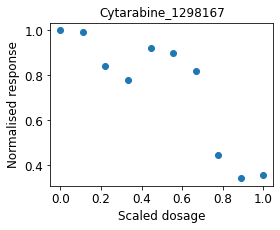

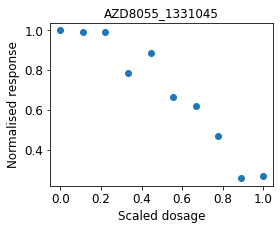

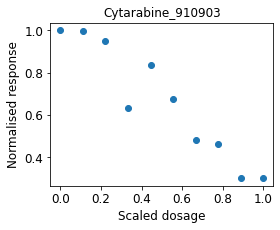

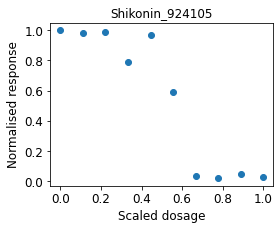

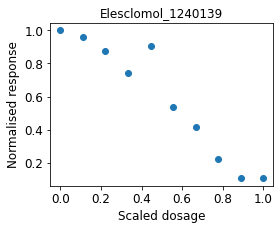

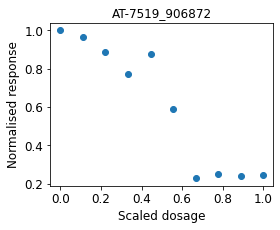

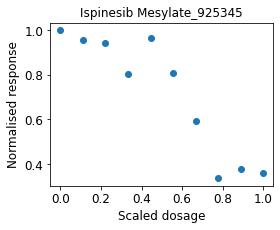

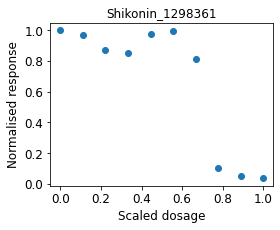

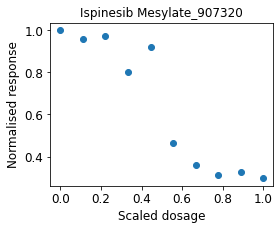

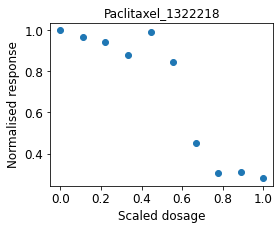

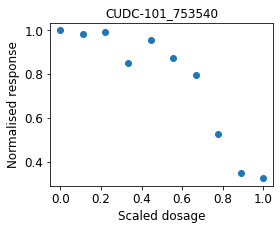

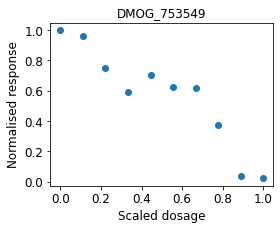

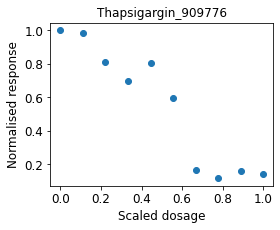

In [25]:
for i, ind in enumerate(df_11.index):
    plt.figure(i)
    drug_id = df_11.loc[ind, "DRUG_ID"]
    cosmic_id = df_11.loc[ind, "COSMIC_ID"]
    show_one(df, drug_id, cosmic_id)

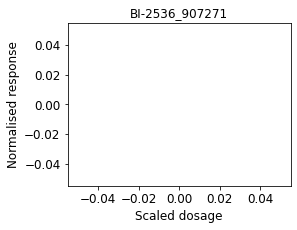

In [26]:
drug_id = 60
cosmic_id = 907271
show_one(df, drug_id, cosmic_id)

### Do we need 2d filtering criteria about first and last points forming plateus?

In [27]:
df3 = FilteringCurves(drug_curves, filtering_scenario=[1,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 44)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 44)


DRUG_ID: 302, COSMIC_ID: 722066, Drug Name: PI-103, CCL: NCI-H650


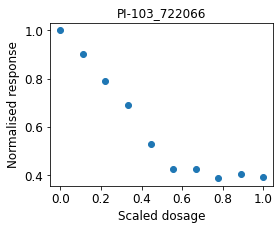

In [28]:
# filtering_scenario=[1,3,4] - why we need restriction for plateus
ind = 131086
drug_id = df3.loc[ind, "DRUG_ID"]
cosmic_id = df3.loc[ind, "COSMIC_ID"]
print("DRUG_ID: {}, COSMIC_ID: {}, Drug Name: {}, CCL: {}".format(drug_id, cosmic_id, drug_names[drug_id], CLL_names[cosmic_id]))
show_one(df3, drug_id, cosmic_id)

DRUG_ID: 276, COSMIC_ID: 1480374, Drug Name: CAY10603, CCL: UWB1.289


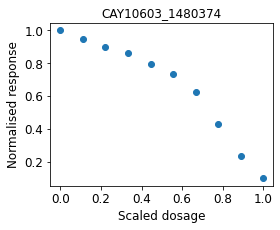

In [29]:
# filtering_scenario=[1,3,4] - why we need restriction for plateus
ind = 131087
drug_id = df3.loc[ind, "DRUG_ID"]
cosmic_id = df3.loc[ind, "COSMIC_ID"]
print("DRUG_ID: {}, COSMIC_ID: {}, Drug Name: {}, CCL: {}".format(drug_id, cosmic_id, drug_names[drug_id], CLL_names[cosmic_id]))
show_one(df3, drug_id, cosmic_id)

In [30]:
# extracting sigmoid forms - adding restriction for plateus
df3_1 = FilteringCurves(df3, filtering_scenario=[2], \
                        response_columns = response_norm, tolerance=0.05,
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)

Original dataset: (16488, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (2600, 46)


In [31]:
df3.shape[0], df3_1.shape[0]

(16488, 2600)

In [32]:
drug_id = 180
cosmic_id = 909730
df3[(df3["DRUG_ID"]==drug_id) & (df3["COSMIC_ID"]==cosmic_id)][["norm_cells_"+str(i) for i in range(10)]].T

,131101
norm_cells_0,1.000000
norm_cells_1,0.922945
norm_cells_2,0.867442
norm_cells_3,0.785392
norm_cells_4,0.501900
norm_cells_5,0.241226
norm_cells_6,0.092333
norm_cells_7,0.074661
norm_cells_8,0.063998
norm_cells_9,0.062790


In [33]:
1.000 - 0.922945

0.07705499999999998

In [34]:
# linear forms: 
lin_ind = set(df3.index)- set(df3_1.index)
df3_2 = df3.loc[lin_ind, :]
print("Sigmoid shape:", df3_1.shape[0])
print("Linear ? shape:", df3_2.shape[0])

Sigmoid shape: 2600
Linear ? shape: 13888


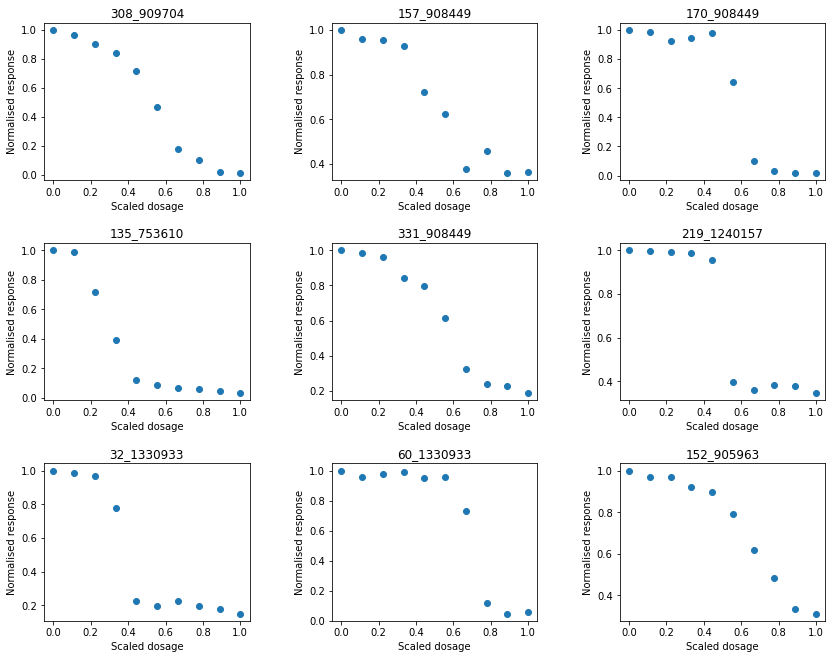

In [35]:
ShowResponseCurves(df3_1, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df3_1.index[:9])

In [36]:
drug_id = 157
cosmic_id = 908449
df[(df["DRUG_ID"]==drug_id) & (df["COSMIC_ID"]==cosmic_id)][["norm_cells_"+str(i) for i in range(10)]].T

,60
norm_cells_0,1.000000
norm_cells_1,0.958112
norm_cells_2,0.953868
norm_cells_3,0.926033
norm_cells_4,0.720981
norm_cells_5,0.622026
norm_cells_6,0.378269
norm_cells_7,0.457085
norm_cells_8,0.358507
norm_cells_9,0.362443


In [37]:
0.378269-0.457085

-0.078816

In [38]:
#df3_1.to_csv(_FOLDER_3+"sigmoid.csv")

In [39]:
df3_2.head(10)

,Unnamed: 0,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,...,per_slope_change_7,slope_0,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8
65543,65543,NCI-H196,1240186,294,294_1240186,2,20.000,0,0.111111,0.222222,...,-104.96,-1.232139,-0.196699,0.645572,-0.055981,0.055410,0.151823,0.172426,0.051645,-5.369003
131086,131086,NCI-H650,722066,302,302_722066,2,10.240,0,0.111111,0.222222,...,-1.70696,-0.872783,-1.015732,-0.882676,-1.448519,-0.956395,0.026700,-0.361916,0.149375,-0.105602
131087,131087,UWB1.289,1480374,276,276_1480374,2,20.000,0,0.111111,0.222222,...,-0.307916,-0.497667,-0.398883,-0.358493,-0.595594,-0.562887,-0.945100,-1.752392,-1.772269,-1.226560
22,22,HDQ-P1,1290922,272,272_1290922,2,5.120,0,0.111111,0.222222,...,-0.709786,-1.428897,-0.442275,-1.256773,-0.460310,0.172309,-1.150468,-1.248002,-1.398412,-0.405838
131096,131096,RD-ES,1330996,228,228_1330996,2,10.240,0,0.111111,0.222222,...,5.34047,-1.064777,-0.280937,0.213673,-0.253518,-0.548294,-1.113210,-1.080428,-0.544200,-3.450489
65560,65560,HEL,907053,223,223_907053,2,5.120,0,0.111111,0.222222,...,4.25737,-0.872616,-0.270015,-0.195266,-0.600387,-0.317749,-0.817999,-0.673445,-0.651637,-3.425899
131100,131100,IM-95,1240155,283,283_1240155,2,0.128,0,0.111111,0.222222,...,-3.74099,-1.464007,-1.327485,-1.248016,0.205013,-1.228511,-0.462302,-0.451986,0.020838,-0.057116
131101,131101,SK-NEP-1,909730,180,180_909730,2,0.512,0,0.111111,0.222222,...,-0.886804,-0.693494,-0.499530,-0.738443,-2.551430,-2.346065,-1.340036,-0.159050,-0.095973,-0.010864
65567,65567,KP-3,1298219,182,182_1298219,2,16.000,0,0.111111,0.222222,...,-0.892455,-1.112600,0.138911,-3.117547,-1.813912,-1.693795,0.406397,-0.273261,-1.323751,-0.142362
65574,65574,HEL,907053,261,261_907053,2,10.240,0,0.111111,0.222222,...,-12.9158,-1.629769,0.792801,-0.732069,-0.162283,0.310668,0.284373,-0.175568,0.474879,-5.658565


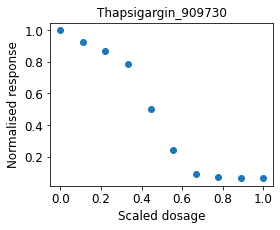

In [40]:
# ind = 131101
# drug_id = df3.loc[ind, "DRUG_ID"]
# cosmic_id = df3.loc[ind, "COSMIC_ID"]

drug_id = 180
cosmic_id = 909730
show_one(df3_2, drug_id, cosmic_id)

In [41]:
drug_id = 180
cosmic_id = 909730
df3[(df3["DRUG_ID"]==drug_id) & (df3["COSMIC_ID"]==cosmic_id)][["norm_cells_"+str(i) for i in range(10)]].T

,131101
norm_cells_0,1.000000
norm_cells_1,0.922945
norm_cells_2,0.867442
norm_cells_3,0.785392
norm_cells_4,0.501900
norm_cells_5,0.241226
norm_cells_6,0.092333
norm_cells_7,0.074661
norm_cells_8,0.063998
norm_cells_9,0.062790


### Labelling

In [43]:
df = drug_curves.copy()
df2 = drug_curves.copy()
indexes= {}
for i in [1,3,4,2]:
    df = FilteringCurves(df, filtering_scenario=[i], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)
    indexes[i] = df.index
    df2.loc[df.index,"filt_"+str(i)]=1

df2.fillna(0, inplace=True)

df2["sum"] = df2[["filt_"+str(i) for i in range(1,5)]].sum(axis=1)
df2["sum"].value_counts() 

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
Original dataset: (63325, 44)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 44)
Original dataset: (19037, 44)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 44)
Original dataset: (16488, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (2600, 46)


0.0    162059
1.0     44288
3.0     13888
4.0      2600
2.0      2549
Name: sum, dtype: int64

### Filtering scenario 1+2+3

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)


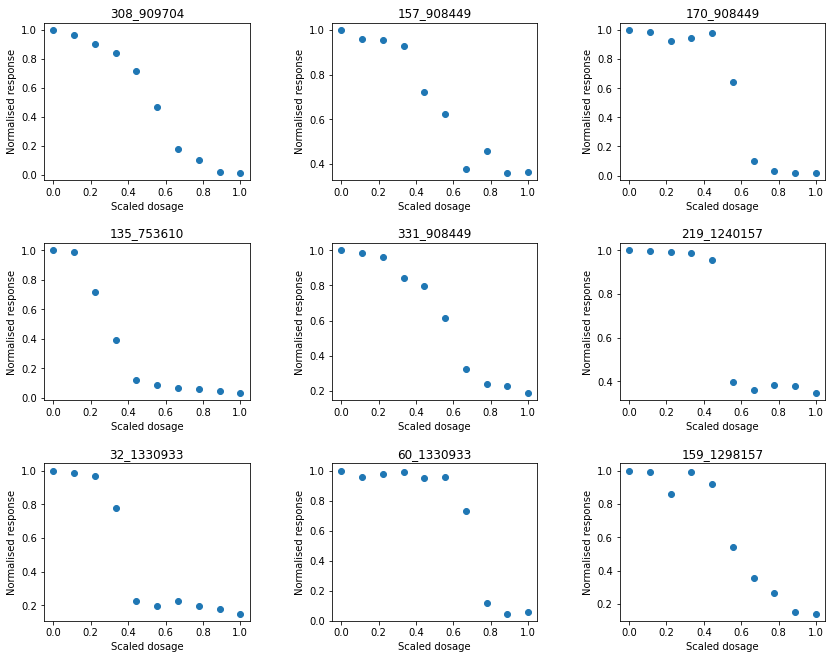

In [44]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 46)


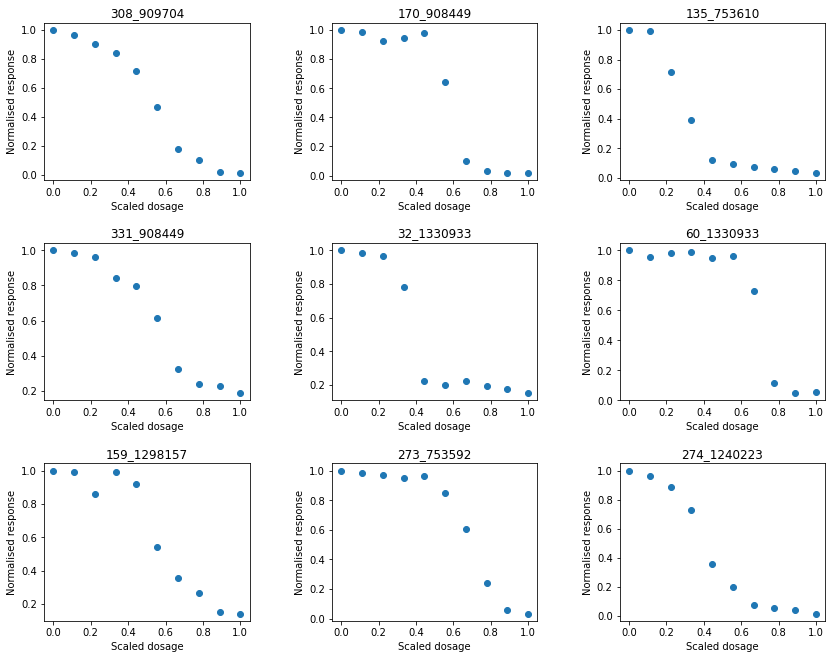

In [45]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

### Filtering scenario 1+2+3+4

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2600, 46)


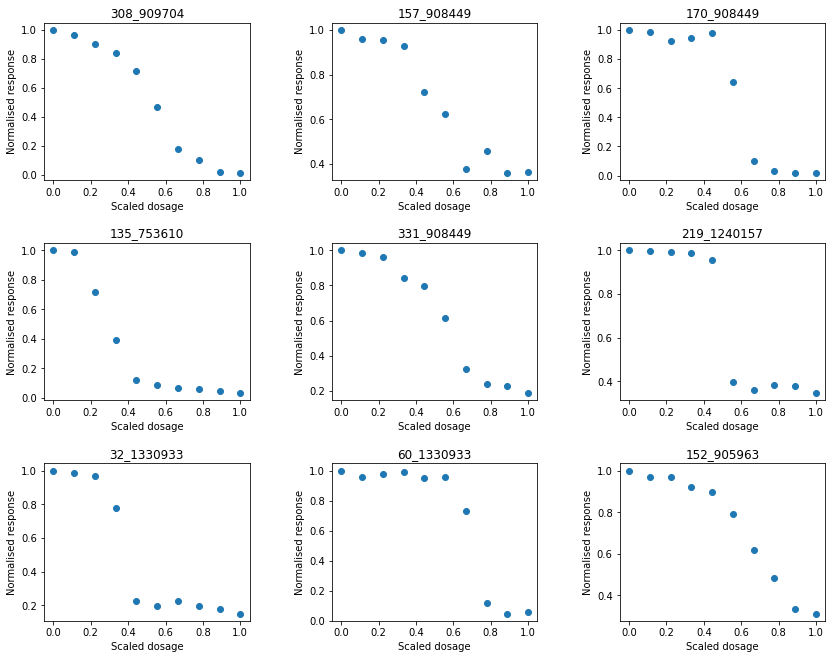

In [50]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4,
                    middle_points_limit = -0.1)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 46)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2037, 46)


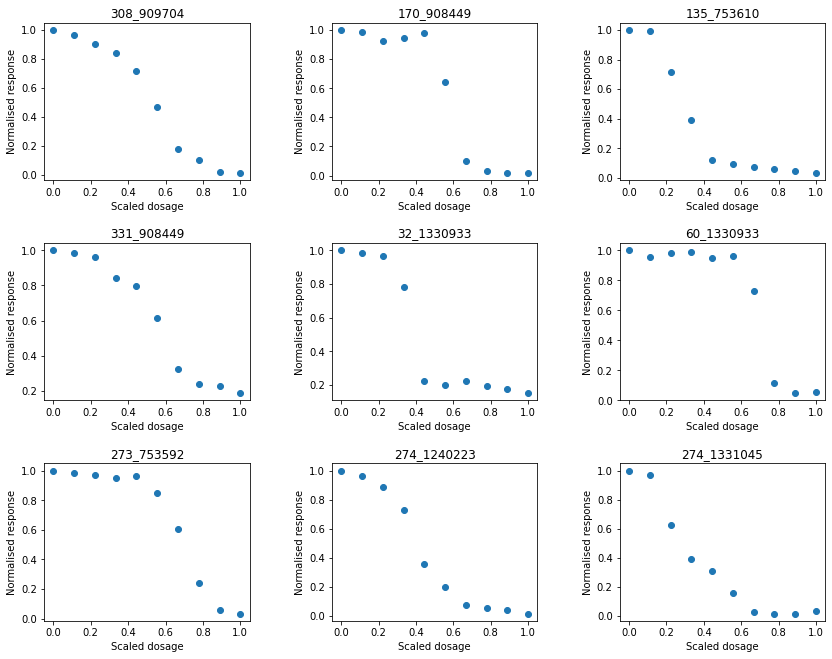

In [51]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2,
                    middle_points_limit = -0.1)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])

### Filtering scenario 1+3+4

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 44)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 44)


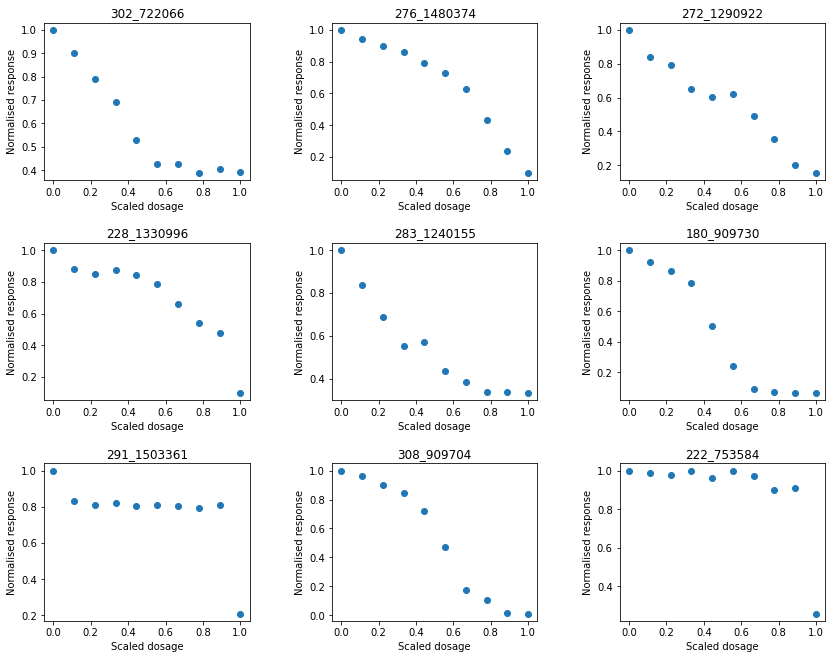

In [49]:
df = FilteringCurves(drug_curves, filtering_scenario=[1,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                     middle_points_limit = -0.1)

ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9])